In [47]:
%matplotlib notebook
import os
from scipy import optimize
from scipy.optimize import leastsq
from numpy import *
import glob
from matplotlib import *
from pylab import *

import matplotlib.font_manager as fm
font_names = [f.name for f in fm.fontManager.ttflist]
mpl.rcParams['font.family'] = 'Times'
mpl.rcParams['mathtext.fontset'] = 'custom'
# mpl.rcParams['mathtext.rm'] = 'Times'
mpl.rcParams['mathtext.it'] = 'Times:italic'
mpl.rcParams['mathtext.bf'] = 'Times'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['axes.formatter.limits'] = [-5,5]

In [66]:
def get_file_detuning(file):
    underscore_locations = [index for index, character in enumerate(file)
                            if character == "_"]
    left = underscore_locations[9] + 1
    right = underscore_locations[10]
    return int(float(file[left:right]))

def get_files():
    os.chdir('/home/henry/Documents/Physics Internship/15112022/27_dBm/Spectrum/')
    files= glob.glob('*.txt')
    return files

def get_detuning_files_dict():
    files = get_files()
    detunings = sorted(list(set([get_file_detuning(file) for file in files])), reverse=True)
    detuning_files_dict = {detuning: [] for detuning in detunings}
    for file in files:
        detuning_files_dict[get_file_detuning(file)].append(file)
    return detuning_files_dict, detunings

def get_file_contents(file):
    with open(file,'r') as f:
        file_contents=f.readlines()
    return file_contents

In [3]:
def convert_to_mW(input_list):
    converted_list = (10**(input_list/10))/1000
    return converted_list

In [29]:
def get_voltage_and_frequency(data):
    data_fields = [[float(number) for number in line.strip().split('\t')]
                   for line in data[1:]]
    voltage, frequency = zip(*data_fields)
    return array(voltage), array(frequency)

def get_S21_detuning(voltage, power):
    power_mW = convert_to_mW(power)
    S21 = voltage/power_mW
    return S21

def get_S21_normalised(S21_list, index_maxima):
    S21_normalised = [S21/S21[index] for S21, index in zip(S21_list, index_maxima)]
    return S21_normalised

In [25]:
def get_index_maximum(frequency, voltage):
    voltage = get_moving_average(voltage, 6)
    max_index = argmax(array(voltage))
    return max_index

def get_moving_average(points, window_width):
    N = len(points)
    window_points = [[points[inside_window(i+j, N)] for i in range(window_width)]
                     for j in range(N)]
    moving_average = array([sum(window)/window_width for window in window_points])
    return moving_average

def inside_window(i, N):
    if i < 0:
        return 0
    elif i > N-1:
        return N-1
    return i

In [6]:
def offset_frequency(frequency, min_index, max_index):
    frequency = frequency[0:len(frequency) - (max_index - min_index)]
    resonant_frequency = frequency[min_index]
    frequency -= resonant_frequency
    return frequency

def get_S21_offset_list(S21_list, min_index, max_index):
    S21_offset_list = [get_S21_offset(S21, index, min_index, max_index)
                       for S21, index in zip(S21_list, index_maxima)]
    return S21_offset_list

def get_S21_offset(S21, index, min_index, max_index):
    left_index = index - min_index
    right_index = len(S21) - (max_index - index)
    S21_offset = S21[left_index:right_index]
    return S21_offset

In [35]:
def create_figure_1(S21_list, filter_rate):
    for index, S21 in enumerate(S21_list):
        if index % filter_rate == 0:
            plot_figure_1(frequency, S21)
    plt.title("Title")
    #plt.xlim(-2*10**7, 3.5*10**7)
    x_ticks = plt.xticks()[0]
    x_labels = [f'{value:.0f}' for value in plt.xticks()[0]/10**3]
    plt.xticks(x_ticks, x_labels)

def plot_figure_1(frequency, voltage):
    figure(1)
    plt.plot(frequency, voltage,'.',alpha=1)
    plt.xlabel('${\omega_c}$ (kHz)')
    plt.ylabel('Amplitude')

In [37]:
def peval(freq,p):
    F = p[0]
    gamma = p[1]
    noise = p[2]
    w = p[3]
    res = (F/(gamma**2+4*(freq-w)**2))+noise
    return res

def residuals(p,X,f):
    res=peval(f,p)-X
    return res

In [50]:
def fit(S21, freq):
    p0=[10e-10, 20, 0.6e-14, 0]
    #p0=[7e-10, 3.53181220e+01, 5.69756968e-14, 4.02844320e+09]
    #p_test = [7e-10, 3.53181220e+01, 5.69756968e-14, 4.02844320e+09]
    plsq=leastsq(residuals,p0,args=(S21,freq),full_output=1)
    p_final=plsq[0]
    return p_final

<IPython.core.display.Javascript object>


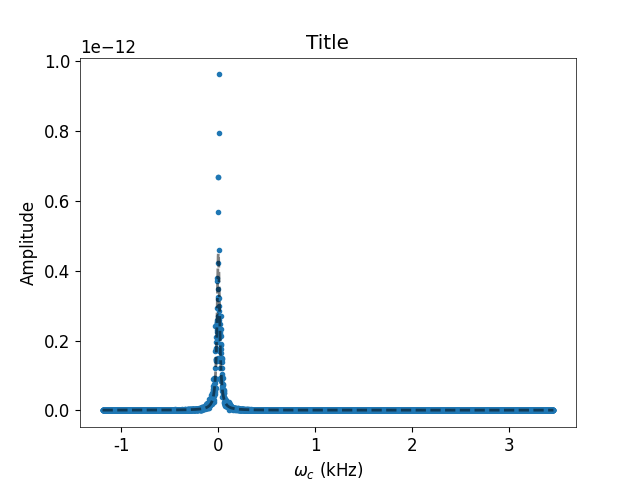

In [67]:
detuning_files_dict, detunings = get_detuning_files_dict()
power = 27
for detuning in detunings[0:1]:
    S21_list_detuning = []
    index_maxima = []
    for file in detuning_files_dict[detuning]:
        raw_data = get_file_contents(file)
        voltage, frequency = get_voltage_and_frequency(raw_data)
        voltage = convert_to_mW(voltage)
        S21_list_detuning.append(get_S21_detuning(voltage, power))
        index_maximum = get_index_maximum(frequency, voltage)
        index_maxima.append(index_maximum)
    
    min_index = min(index_maxima)
    max_index = max(index_maxima)
    frequency = offset_frequency(frequency, min_index, max_index)
    S21_offset_list = get_S21_offset_list(S21_list_detuning, min_index, max_index)
    S21_average = average(S21_offset_list, axis=0)
    create_figure_1([S21_average], 1)
    p_final = fit(S21_average, frequency)
    plt.plot(frequency,peval(frequency, p_final),'k--', alpha=0.5,linewidth=2.0,label='fit')